Image loading and pre-processing

**cite: https://www.kaggle.com/waterchiller/vgg16-classification-dog-breed**

In [1]:
from datetime import datetime
import tensorboard
import keras

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.layers import Input, Dense,BatchNormalization,Activation, GaussianDropout,SeparableConv2D, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16, ResNet50, VGG19, Xception
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt
import cv2


In [3]:
img_size=(128,128)
channels=3

In [4]:
run_name='dogml_custom'
# Define the Keras TensorBoard callback.
logdir=f"logs/{run_name}/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


In [5]:
BASEPATH = "./dog_data/images/Images/"
LABELS = set()

paths = []
    
for d in os.listdir(BASEPATH):
    LABELS.add(d)
    paths.append((BASEPATH+d, d))

In [6]:
# resizing and converting to RGB
def load_and_preprocess_image(path):
    image = cv2.imread(path)
    image = cv2.resize(image, img_size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [7]:
X = []
y = []

for path, label in paths:
    for image_path in os.listdir(path):
        image = load_and_preprocess_image(path+"/"+image_path)
        
        X.append(image)
        y.append(label)

In [8]:
encoder = LabelBinarizer()

X = np.array(X)
y = encoder.fit_transform(np.array(y))

print(y[0])

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


(3633, 128, 128, 3)
(3633, 20)


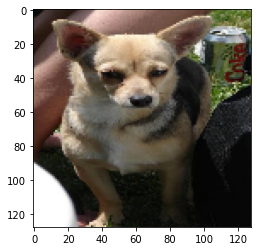

In [9]:
print(X.shape)
print(y.shape)
plt.imshow(X[0])

A create our own?
transfer learning (options: Xception/VGG16/VGG19/ResNet50)

tensorflow specific preprocessing:
notable functions 'path(s) to tensor'

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.007)


model = Sequential()

model.add(SeparableConv2D(64,(3,3),activation="relu", padding="same"))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(SeparableConv2D(128,(3,3),activation="relu", padding="same"))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),activation="relu", padding="same"))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),activation="relu", padding="same"))
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3),activation="relu", padding="same"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(1024,activation="relu"))
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(1024,activation="relu"))
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.2))

#model.add(Dense(len(LABELS),activation="softmax"))
##signoid
   
model.compile("adam",loss="categorical_crossentropy",metrics=["accuracy"])


In [10]:
early_stopping = EarlyStopping(monitor="categorical_accuracy", patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=6)

In [11]:
X.shape

(3633, 128, 128, 3)

In [12]:
dogm = Sequential(layers=[
    Input(shape=(*img_size,channels)),
    SeparableConv2D(256,(3,3),activation="relu", padding="same"),
    BatchNormalization(),
    Activation('relu'),
    GlobalAveragePooling2D(),
    Dense(1024,activation='relu'),
    GaussianDropout(0.1),
    Dense(512,activation='relu'),
    Dense(len(LABELS),activation='softmax'),
    ])
dogm.compile("adam",loss="categorical_crossentropy",metrics=["categorical_accuracy"])

In [23]:
dogm.fit(X,y,
          batch_size=100,
          epochs=135,
          shuffle=True,
          validation_split=0.2,
          #validation_data=(X_test,y_test), 
          validation_freq=1,
          use_multiprocessing=True,
          callbacks=[tensorboard_callback, early_stopping])

Epoch 1/135
30/30 [==============================] - 16s 542ms/step - loss: 0.5308 - categorical_accuracy: 0.8410 - val_loss: 32.7080 - val_categorical_accuracy: 0.0028
Epoch 2/135
30/30 [==============================] - 13s 432ms/step - loss: 0.6024 - categorical_accuracy: 0.8049 - val_loss: 30.9000 - val_categorical_accuracy: 0.0041
Epoch 3/135
30/30 [==============================] - 13s 431ms/step - loss: 0.5385 - categorical_accuracy: 0.8400 - val_loss: 30.0585 - val_categorical_accuracy: 0.0028
Epoch 4/135
30/30 [==============================] - 13s 431ms/step - loss: 0.5069 - categorical_accuracy: 0.8469 - val_loss: 30.2494 - val_categorical_accuracy: 0.0041
Epoch 5/135
30/30 [==============================] - 13s 431ms/step - loss: 0.6112 - categorical_accuracy: 0.8176 - val_loss: 31.7347 - val_categorical_accuracy: 0.0041
Epoch 6/135
30/30 [==============================] - 13s 432ms/step - loss: 0.5043 - categorical_accuracy: 0.8507 - val_loss: 31.6556 - val_categorical_acc

In [24]:
loss, acc = dogm.evaluate(X,y,verbose=0)
print(f"loss on the *whole* set is {loss:.2f}")
print(f"accuracy on the *whole* set is {acc:.3f}")

dogm.save(f'{run_name}_model.h5')

loss on the *whole* set is 6.73
accuracy on the *whole* set is 0.751


In [14]:
base_model=ResNet50(weights='imagenet',include_top=False)

x=base_model.output
x=SeparableConv2D(64,(3,3),activation="relu", padding="same")(x)
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
x=GaussianDropout(0.4)(x)
x=Dense(512,activation='relu')(x)
preds=Dense(len(LABELS),activation='softmax')(x)

model=Model(inputs=base_model.input,
            outputs=preds)

for layer in model.layers[:-9]:
     layer.trainable=False
for layer in model.layers[-9:]:
     layer.trainable=True
    

In [15]:

model.compile("adam",loss="categorical_crossentropy",metrics=["categorical_accuracy"])

print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [20]:
model.fit(X,y,
          batch_size=200,
          epochs=135,
          shuffle=True,
          validation_split=0.2,
          #validation_data=(X_test,y_test), 
          validation_freq=1,
          use_multiprocessing=True,
          callbacks=[tensorboard_callback, early_stopping])

Epoch 1/135
15/15 [==============================] - 7s 483ms/step - loss: 0.0114 - categorical_accuracy: 0.9962 - val_loss: 12.3643 - val_categorical_accuracy: 0.0220
Epoch 2/135
15/15 [==============================] - 5s 301ms/step - loss: 0.0154 - categorical_accuracy: 0.9955 - val_loss: 12.5141 - val_categorical_accuracy: 0.0220
Epoch 3/135
15/15 [==============================] - 5s 302ms/step - loss: 0.0174 - categorical_accuracy: 0.9959 - val_loss: 13.4368 - val_categorical_accuracy: 0.0454
Epoch 4/135
15/15 [==============================] - 5s 301ms/step - loss: 0.0294 - categorical_accuracy: 0.9924 - val_loss: 14.7534 - val_categorical_accuracy: 0.0330
Epoch 5/135
15/15 [==============================] - 5s 301ms/step - loss: 0.0365 - categorical_accuracy: 0.9873 - val_loss: 16.4581 - val_categorical_accuracy: 0.0289
Epoch 6/135
15/15 [==============================] - 5s 302ms/step - loss: 0.0438 - categorical_accuracy: 0.9890 - val_loss: 15.7066 - val_categorical_accuracy:

In [21]:
loss, acc = model.evaluate(X,y,verbose=0)
print(f"loss on the *whole* set is {loss:.2f}")
print(f"accuracy on the *whole* set is {acc:.3f}")

model.save(f'{run_name}_model.h5')

loss on the *whole* set is 2.51
accuracy on the *whole* set is 0.798
